# Full VE problem analysis template

In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import sympy as sym
import torch

sys.path.append('../src')
import VE_params

np_seed = 2
torch_seed = 0
np.random.seed(np_seed)
torch.manual_seed(torch_seed)

## Data generation

> The below cell is very important for preparing the generation, examination, and saving of the data. It is one of only a few cells that requires configuration in the notebook.

Specify the model parameters

In [2]:
input_type = 'Strain' # Stated up here as it also decides if model is GMM or GKM (strain -> GMM).
mech_model = 'GKM'

In [3]:
# E_alt = np.array(E[1:])
# eta_alt = np.array(eta)
# tau = eta_alt/E_alt
# tau

Specify the functional form of the input

In [4]:
func_desc = 'half sinc'

#t = sym.symbols('t', real=True)
#input_expr = sym.sinc(omega*t)

# Wave packets
# omega = 2.5
# amp = 7
# input_expr, d_input_expr, input_torch_lambda = VE_datagen.wave_packet_lambdas_sum(omega, 0.5, 3, amp)

# step
# input_expr = lambda t: 1
# d_input_expr = lambda t: 0
# input_torch_lambda = lambda t: 1 + 0*t

# width_val = 0.1
# input_expr = sigmoid_expr(width=width_val)
# d_input_expr = d_sigmoid_expr(width=width_val)
# input_torch_lambda = sigmoid_torch_expr(width=width_val)

# sine
# omega = 1
# input_expr = lambda t: np.sin(omega*t)
# d_input_expr = lambda t: omega*np.cos(omega*t)
# input_torch_lambda = lambda t: torch.sin(omega*t)

# sinc
omega = np.pi
Amp = 7
input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
# d_input_expr_1 = lambda t: (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
input_torch_lambda = lambda t: Amp*torch.sin(omega*t)/(omega*t)

# sinc with hshift
# omega = 1
# shift = 6*np.pi
# input_expr = lambda t: np.sin(omega*(t - shift))/(omega*(t - shift))
# d_input_expr = lambda t: (1/(t - shift))*(np.cos(omega*(t - shift)) - np.sin(omega*(t - shift))/(omega*(t - shift)))
# input_torch_lambda = lambda t: torch.sin(omega*(t - shift))/(omega*(t - shift))

# sinc with vshift
# omega = np.pi
# neg_edge = -7.5 # for now is 3.75*T where T is 2*pi/omega. The 3.75 is chosen but could be any (n +- 0.25) where n is integer > 0.
# input_expr_no_shift = lambda t: np.sin(omega*t)/(omega*t)
# vshift = input_expr_no_shift(neg_edge)
# input_expr = lambda t: input_expr_no_shift(t) - vshift
# d_input_expr = lambda t: (1/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
# input_torch_lambda = lambda t: torch.sin(omega*t)/(omega*t) - vshift

# sinc with both hshift and vshift
# omega = np.pi
# hshift = 7.5 # for now is 3.75*T where T is 2*pi/omega. The 3.75 is chosen but could be any (n +- 0.25) where n is integer > 0.
# input_expr_h_only = lambda t: np.sin(omega*(t - hshift))/(omega*(t - hshift))
# vshift = input_expr_h_only(0)
# input_expr = lambda t: input_expr_h_only(t) - vshift
# d_input_expr = lambda t: (1/(t - shift))*(np.cos(omega*(t - shift)) - np.sin(omega*(t - shift))/(omega*(t - shift)))
# input_torch_lambda = lambda t: torch.sin(omega*(t - hshift))/(omega*(t - hshift)) - vshift

# soft step
# def sigmoid_expr(max_value=1, h_shift=0, width=1):
#     return lambda t: max_value / (1 + np.exp(-(t-h_shift)/width))

# def d_sigmoid_expr(max_value=1, h_shift=1, width=1): # h_shift is wrong
#     sig = sigmoid_expr(h_shift=h_shift, width=width)
#     return lambda t: (max_value/width) * sig(t) * (1 - sig(t))

# def sigmoid_torch_expr(max_value=1, h_shift=0, width=1):
#     return lambda t: max_value / (1 + torch.exp(-(t-h_shift)/width))

# width_val = 0.1
# shift_val = 5*(-2*np.pi/omega)
# input_expr_2 = sigmoid_expr(h_shift=shift_val, width=width_val)
# # d_input_expr_2 = d_sigmoid_expr(h_shift=shift_val, width=width_val)
# input_torch_lambda_2 = sigmoid_torch_expr(h_shift=shift_val, width=width_val)

## Load in response data

In [5]:
# general_path = 'Oscilloscope data CRI electronics analogy/'
# specific_path = 'AWG 7V half sinc KELVIN 1 cap/' # It is precisely here that changes the data we are grabbing to test.
# path = general_path + specific_path

channel_2_data = np.loadtxt('Channel 2 voltage shunt resistor.csv', delimiter=',', skiprows=3)

Need to clip to data series that will be as a result of the analytical expression - no discontinuities!

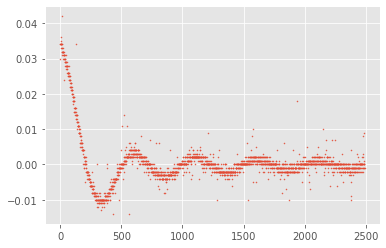

In [6]:
plt.plot(channel_2_data[810:3300, 1], linestyle='None', marker='.', markersize=1)

In [7]:
lower = 810
upper = 3300

voltage_shunt_array = channel_2_data[lower:upper, 1:]
time_array = channel_2_data[lower:upper, :1]

In [8]:
r_0 = 1.99e3 # measured using multimeter
r_1 = 1.99e3 # measured using multimeter
r_2 = 1.99e3 # measured using multimeter

equiv_E = [1/r_0, 1/r_1]
equiv_eta = [1e-3]

In [9]:
# Maxwell shunt
# r_shunt = 10.2 # measured using multimeter
# Kelvin shunt
r_shunt = 10.2 # measured using multimeter

current_array = voltage_shunt_array/r_shunt

## Generate manipulation data profile

Shift time array to start almost at 0

In [10]:
time_array = time_array - min(time_array) + 10**-10

In [11]:
voltage_array = input_expr(time_array)

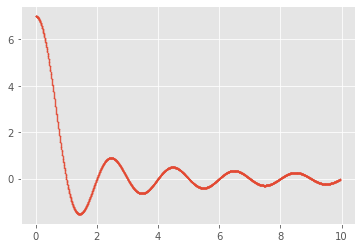

In [12]:
plt.plot(time_array, voltage_array, label='voltage', linestyle='None', marker='.', markersize=1)

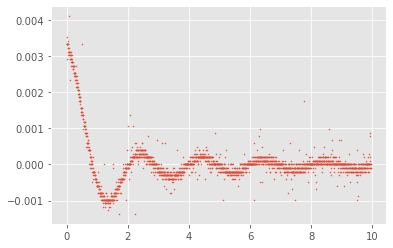

In [13]:
plt.plot(time_array, current_array, label='current', linestyle='None', marker='.', markersize=1)

## Data Treatment

Presence of t/time_sf in new lambdas is hard to understand but has a reason. The reason is that while unscaled t, stress and strain all map to each other, they need to all map once scaled also. Scaling the time array does not change the target array as these are both precalculated. however, because the analytical input data is calculated based off this NEW SCALED time series in the library function, it is calculated over the scaled time series for the old function, effectively doubling the number of bumps in the curve, rather than stretching it out. we want to calculate the old input_data, ie that originates from the unscaled time data, so we have to unscale the time data on the fly in the library, hence the factor in the lambda function.

This allows PyTorch to map scaled time to scaled input and calculate the appropriate derivatives

Note, this is not an issue for the real data as there is no analytical input term, and the input variable is a dumb target, just like the output variable.

In [14]:
# 'normalising'
time_sf = omega/1.2
V_sf = 1/np.max(abs(voltage_array))
I_sf = 1/np.max(abs(current_array))
print(time_sf, V_sf, I_sf)

scaled_time_array = time_array*time_sf
if input_type == 'Strain':
    scaled_input_expr = lambda t: V_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: V_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = I_sf*current_array
elif input_type == 'Stress':
    scaled_input_expr = lambda t: I_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: I_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = voltage_array*V_sf

2.6179938779914944 0.14285714285714285 242.85714285714283


In [15]:
# add noise
noise_level = 0

noisy_target_array = scaled_target_array + noise_level * np.std(scaled_target_array) * np.random.standard_normal(scaled_target_array.shape)

In [16]:
# sampling
number_of_samples = 1000

reordered_row_indices = np.random.permutation(scaled_time_array.size)

reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = noisy_target_array[reordered_row_indices, :][:number_of_samples]

# The below code is a slight alternative version that produces data and targets that are still in chronological order.
# selected_row_indices = reordered_row_indices[:number_of_samples]
# selected_row_indices.sort()
# reduced_time_array = scaled_time_array[selected_row_indices, :]
# reduced_target_array = noisy_target_array[selected_row_indices, :]

## Predicting Coefficients

In [17]:
unscaled_coeffs = VE_params.coeffs_from_model_params(equiv_E, equiv_eta, mech_model)
unscaled_coeffs

[0.502512562814070, 2000.00000000000, 1990.00000000000]

Scale the true coeffs to what deepmod should find based on the scaling of each term in the equation.

In [18]:
expected_coeffs = VE_params.scaled_coeffs_from_true(unscaled_coeffs, time_sf, V_sf, I_sf)
expected_coeffs

[0.191945660010326, 0.449378662847705, 1.17058823529412]

## Defining Library

In [19]:
import torch.autograd as auto
    
def mech_library(inputs, **library_config):    
    
    prediction, data = inputs
    
    input_theta = library_config['input_theta']
    if data.shape[0] == 1: # Swaps real input_theta out for dummy in initialisation pass.
        input_theta = torch.ones((1, input_theta.shape[1]))
    
    # Next use the result of the feedforward pass of the NN to calculate derivatives of your prediction with respect to time. 
    output_derivs = auto_deriv(data, prediction, library_config['diff_order'])
    output_theta = torch.cat((prediction, output_derivs), dim=1)
    
    # Next identify the input/output as Stress/Strain and organise into returned variables
    input_type = library_config['input_type']
    if input_type == 'Strain':
        strain = input_theta
        stress = output_theta
    elif input_type == 'Stress':
        strain = output_theta
        stress = input_theta
    else:
        print('Improper description of input choice. Was: '+input_type+'. Should be either \'Strain\' or \'Stress\'')
        
    strain_t = strain[:, 1:2] # Extract the first time derivative of strain
    strain = torch.cat((strain[:, 0:1], strain[:, 2:]), dim=1) # remove this before it gets put into theta
    strain *= -1 # The coefficient of all strain terms will always be negative. rather than hoping deepmod will find these negative terms, we assume the negative factor here and later on DeepMoD will just find positive coefficients
    theta = torch.cat((strain, stress), dim=1) # I have arbitrarily set the convention of making Strain the first columns of data
    
    return [strain_t], theta


def auto_deriv(data, prediction, max_order):
    '''
    data and prediction must be single columned tensors.
    If it is desired to calculate the derivatives of different predictions wrt different data, this function must be called multiple times.
    This function does not return a column with the zeroth derivative (the prediction).
    '''
    
    # First derivative builds off prediction.
    derivs = auto.grad(prediction, data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
    for _ in range(max_order-1):
        # Higher derivatives chain derivatives from first derivative.
        derivs = torch.cat((derivs, auto.grad(derivs[:, -1:], data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]), dim=1)
            
    return derivs

## DeepMod prep

In [20]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

#### Manipulation derivative library pre-calculation

In [21]:
library_diff_order = 2

input_data = scaled_input_torch_lambda(time_tensor)
input_derivs = auto_deriv(time_tensor, input_data, library_diff_order)
input_theta = torch.cat((input_data.detach(), input_derivs.detach()), dim=1)

#### Config dictionaries

In [22]:
library_config = {'library_func': mech_library,
                  'diff_order': library_diff_order,
                  'coeff_sign': 'positive',
                  'input_type': input_type,
                  'input_theta': input_theta}